In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import datetime as dt
from scipy.stats import mstats

## Data and Data PreProcessing

In [2]:
# Importing Craftbeer data from exel file
import pandas as pd
df = pd.read_excel("IMB881.xlsx", sheet_name="Raw Data-Order and Sample")

# rename "Custorderdate" columns name to "Date"
df = df.rename(columns={"Custorderdate": "Date"})

df.columns


Index(['OrderType', 'OrderCategory', 'CustomerCode', 'CountryName',
       'CustomerOrderNo', 'Date', 'UnitName', 'QtyRequired', 'TotalArea',
       'Amount', 'ITEM_NAME', 'QualityName', 'DesignName', 'ColorName',
       'ShapeName', 'AreaFt'],
      dtype='object')

In [3]:
# get the year month and first day of the month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['YearMonth'] = df['Date'].dt.strftime('%Y-%m-01')

df = df[df['YearMonth']>"2017-01-01"]

In [4]:
# remove outliers

df["Amount"] = mstats.winsorize(df['Amount'], limits=[0.00, 0.05])

In [5]:
df_monthly = df.groupby(['YearMonth']).agg({'Amount': 'sum'}) #.reset_index()
df_monthly.head()

,Amount
YearMonth,
2017-02-01,138647.3176
2017-03-01,102990.2525
2017-04-01,223202.8392
2017-05-01,89772.6300
2017-06-01,166760.7218


<Axes: title={'center': 'Monthly Sales'}, xlabel='YearMonth'>

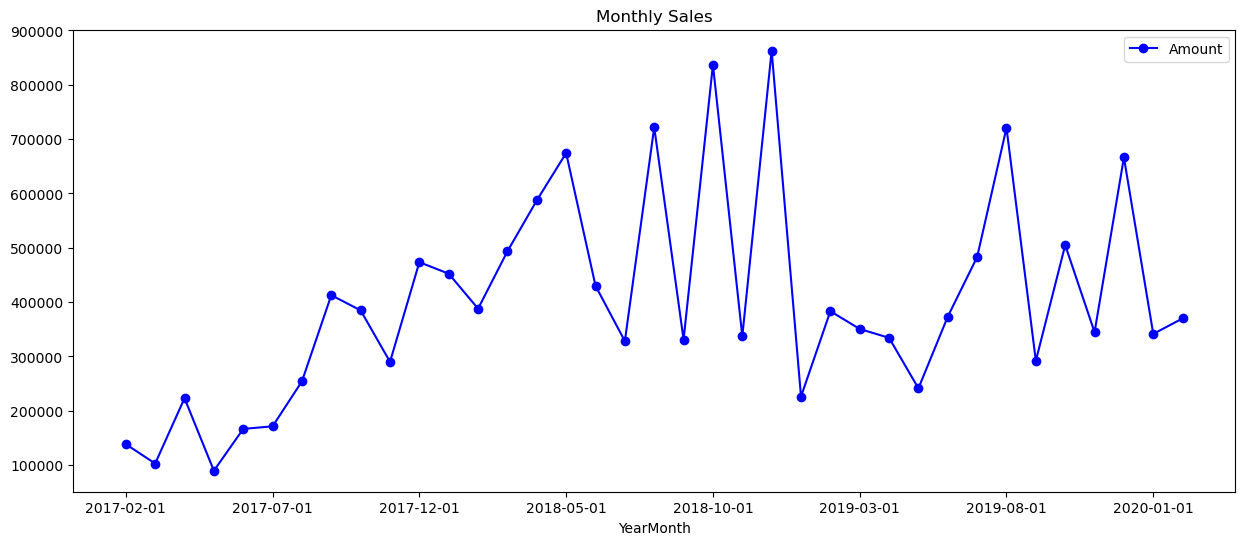

In [6]:
df_monthly.plot(figsize=(15, 6), marker='o', color='blue', title='Monthly Sales')

<Axes: title={'center': 'Monthly Sales'}, xlabel='Date'>

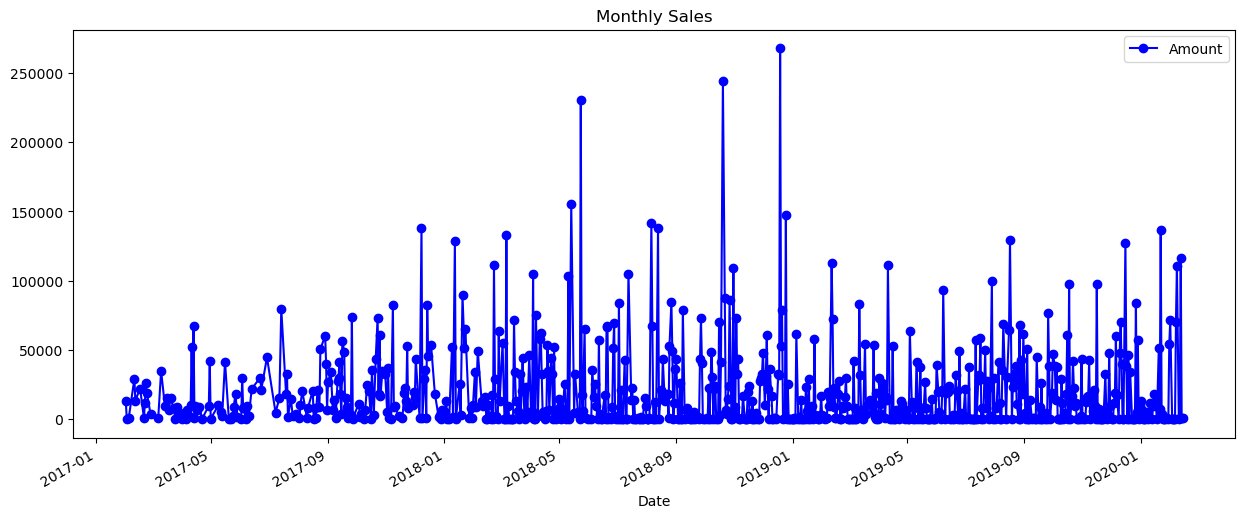

In [7]:
df_daily = df.groupby(['Date'])['Amount'].sum().reset_index()

df_daily.set_index("Date").plot(figsize=(15, 6), marker='o', color='blue', title='Monthly Sales')

<Axes: xlabel='day_of_week_name'>

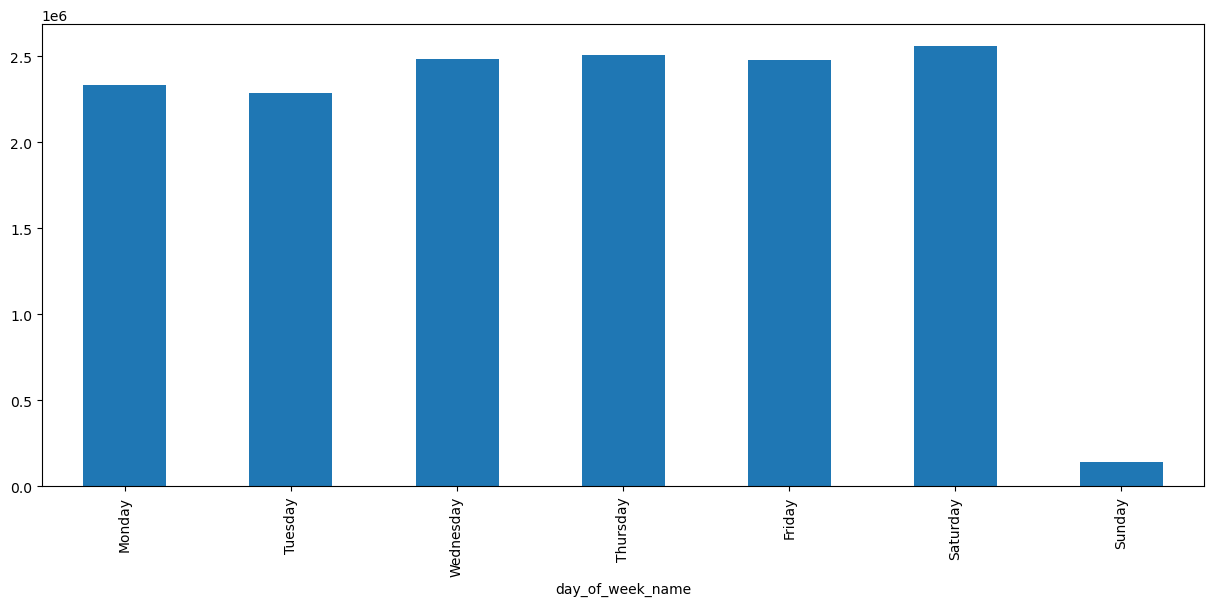

In [8]:

df_daily["day_of_week"] = df_daily["Date"].dt.day_of_week
df_daily["day_of_week_name"] = df_daily["Date"].dt.day_name()
df_weekday = df_daily.groupby(["day_of_week", "day_of_week_name"])["Amount"].sum().reset_index()

df_weekday.sort_values("day_of_week").set_index("day_of_week_name")["Amount"].plot(kind='bar', figsize=(15, 6))

Combination of date in one column and changing the name of them to ds and y

In [9]:
df_daily= df_daily.rename(columns={'Date': 'ds','Amount': 'y',})

df_daily = df_daily[['ds', 'y']]
df_daily["y"] = df_daily["y"].apply(lambda x: np.log(x) if x>0 else np.nan)
df_daily.tail()

,ds,y
768,2020-02-10,NaN
769,2020-02-11,5.963644
770,2020-02-12,11.661937
771,2020-02-13,6.490724
772,2020-02-14,6.602724


## Train_Test Data

In [10]:
df_daily["ds"] = pd.to_datetime(df_daily["ds"])

df_daily_test = df_daily[(df_daily['ds']>=dt.datetime(2019, 1, 1))]
df_daily_train = df_daily[(df_daily['ds']<dt.datetime(2019, 1, 1))]

df_daily_test = df_daily_test.reset_index(drop = True)
df_daily_train = df_daily_train.reset_index(drop = True)

Text(0.5, 1.0, 'Autocorrelation Plot')

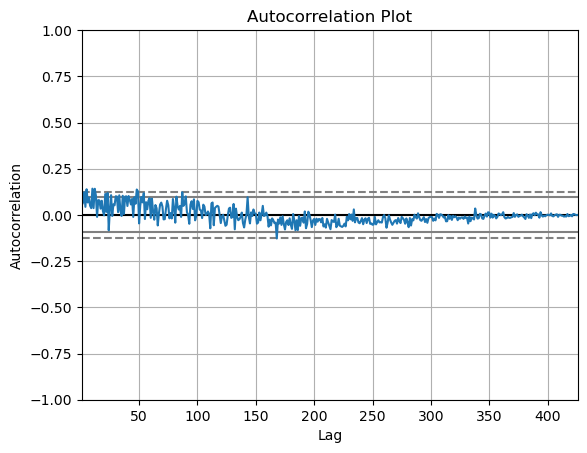

In [11]:
from pandas.plotting import autocorrelation_plot
data = np.array(df_daily_train['y'].fillna(0))
autocorrelation_plot(data)
plt.title('Autocorrelation Plot')

## Prophet

In [12]:

m = Prophet()
m.fit(df_daily_train)

11:03:03 - cmdstanpy - INFO - Chain [1] start processing
11:03:04 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
#future = m.make_future_dataframe(periods=df_daily_test.shape[0], include_history=False)
future = df_daily_test[['ds']]
future.head()


,ds
0,2019-01-01
1,2019-01-02
2,2019-01-03
3,2019-01-04
4,2019-01-05


In [14]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(12)


,ds,yhat,yhat_lower,yhat_upper
0,2019-01-01,9.784646,7.143663,12.232992
1,2019-01-02,9.403900,6.795878,11.995404
2,2019-01-03,9.632326,7.286416,11.954462
3,2019-01-04,9.511626,7.001754,12.070168
4,2019-01-05,8.978824,6.534434,11.637258
5,2019-01-07,9.480799,6.952781,11.772377
6,2019-01-08,9.791484,7.206980,12.356313
7,2019-01-09,9.410739,6.908740,11.963549
8,2019-01-10,9.639165,7.034465,12.155511
9,2019-01-11,9.518464,7.117336,12.023321


C:\Users\asmaa\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\asmaa\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


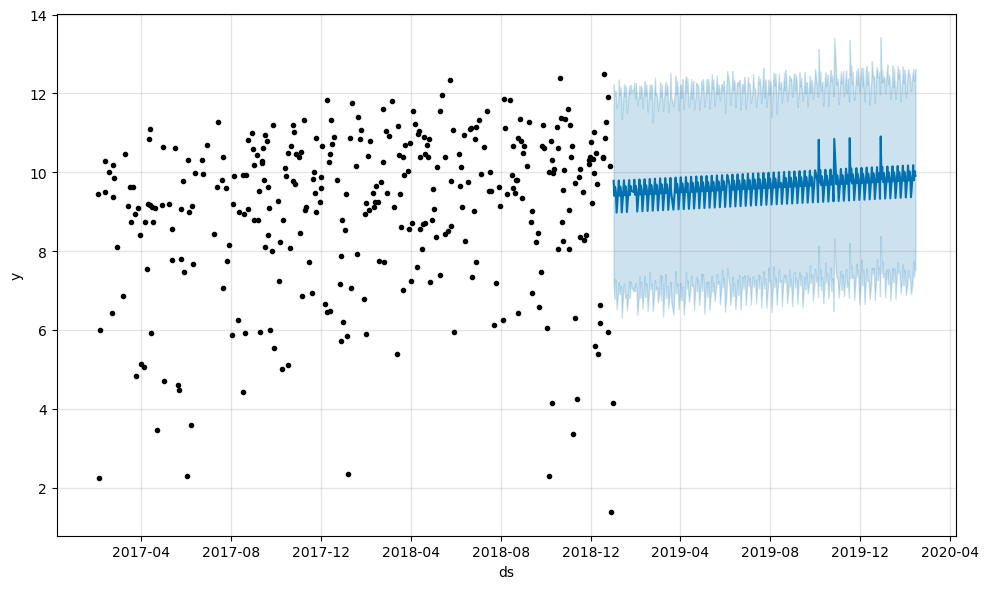

In [15]:
fig1 = m.plot(forecast)

C:\Users\asmaa\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


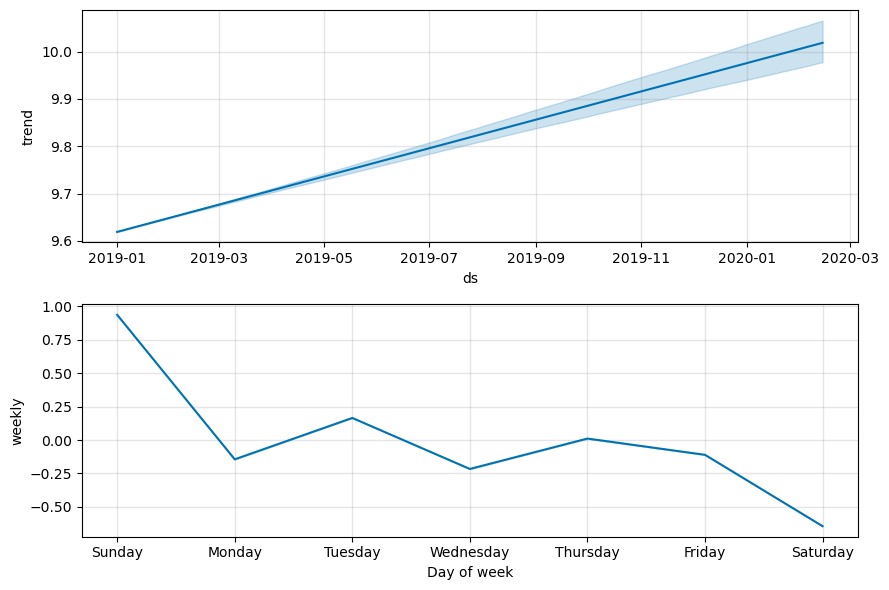

In [18]:
fig2 = m.plot_components(forecast)


In [16]:
forecast["y_actual"] = df_daily_test["y"].values

<Axes: title={'center': 'Daily Sales'}, xlabel='ds'>

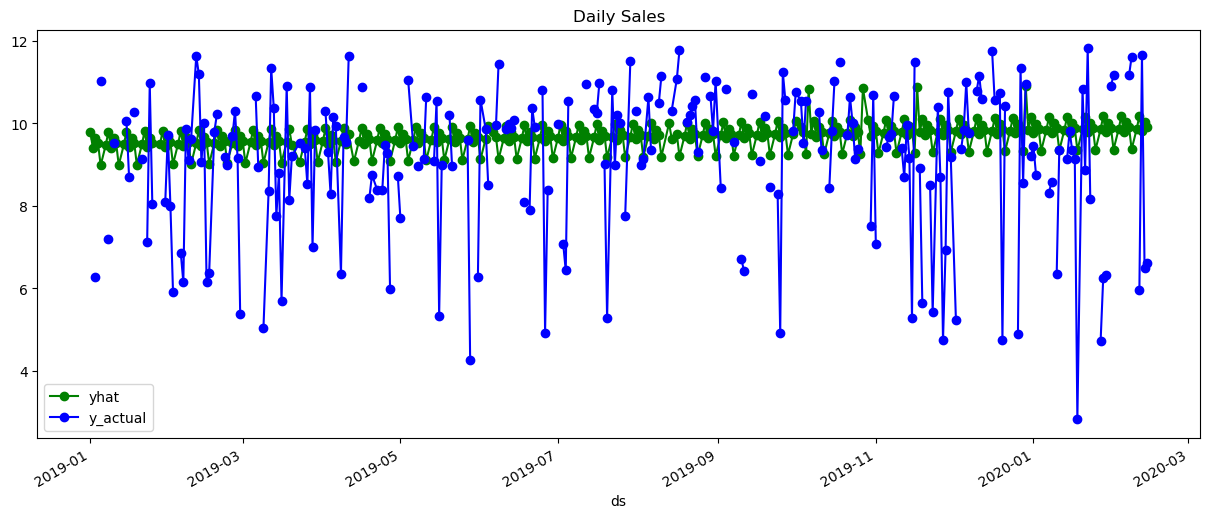

In [17]:
forecast[['ds', 'yhat', 'y_actual']].set_index("ds").plot(figsize=(15, 6), marker='o', color=['green', 'blue'], title='Daily Sales')